In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import toml
import torch
from statsmodels.stats.multitest import multipletests
from torch.utils.data import DataLoader
from m6anet.utils.builder import random_fn
from m6anet.utils.data_utils import NanopolishDS, inference_collate
from m6anet.model.model import MILModel
from tqdm.notebook import tqdm
from pyensembl import Genome
from multiprocessing import Pool

In [2]:
def create_dl(input_dir, batch_size, num_workers):
    ds = NanopolishDS(input_dir, MIN_READS, NORM_PATH, mode='Inference')
    dl = DataLoader(ds, num_workers=num_workers, collate_fn=inference_collate, 
                    batch_size=batch_size, worker_init_fn=random_fn, shuffle=False)
    return dl

def get_read_level_probability(model, dl, device, n_iterations=1):
    """
    Run inference on unlabelled dataset
    """
    model.eval()
    all_y_pred = []
    with torch.no_grad():
        for n in range(n_iterations):
            y_pred_tmp = []
            for batch in dl:
                X = {key: val.to(device) for key, val in batch.items()}
                y_pred = model.get_read_probability(X)
                y_pred = 1 - torch.prod(1 - y_pred, axis=1)
                y_pred = y_pred.detach().cpu().numpy()
                if (len(y_pred.shape) == 1) or (y_pred.shape[1] == 1):
                    y_pred_tmp.extend(y_pred.flatten())
                else:
                    y_pred_tmp.extend(y_pred[:, 1])

            all_y_pred.append(y_pred_tmp)
    return np.mean(all_y_pred, axis=0)


In [11]:
ROOT_PATH = "/home/christopher/m6anet/m6anet/"
NORM_PATH = os.path.join(ROOT_PATH, "model/norm_factors/norm_dict.joblib")
DEFAULT_MODEL_CONFIG =  os.path.join(ROOT_PATH, "model/configs/model_configs/1_neighbor/prod_pooling_attention.toml")
DEFAULT_MODEL_WEIGHTS = os.path.join(ROOT_PATH, "model/model_states/attention_pooling_pr_auc.pt")
MIN_READS = 20

device = 'cuda:2'
model_config = toml.load(DEFAULT_MODEL_CONFIG)
model_state_dict = torch.load(DEFAULT_MODEL_WEIGHTS, map_location=torch.device(device))

model = MILModel(model_config).to(device)
model.load_state_dict(model_state_dict)
model.eval()
batch_size = 512
num_workers = 25
hek293_dirs = ["/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTLE3-KO-25_directRNA_Rep1-Run1",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTLE3-KO-50_directRNA_Rep1-Run1",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTLE3-KO-75_directRNA_Rep1-Run1",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTL3-KO_directRNA_Rep2_Run1"]
hek293_dls = {input_dir.split("/")[-1]: create_dl(input_dir, batch_size, num_workers) for 
              input_dir in hek293_dirs}

In [12]:
test_key = list(hek293_dls.keys())[0]
test_dl = hek293_dls[test_key]
test_batch = next(iter(test_dl))

In [20]:
attention_weights = []
for batch in test_dl:
    attention_weights.append(model.get_attention_weights({key: value.to(device) for key, value in batch.items()})\
                                 .detach().cpu().numpy().flatten())
attention_weights = np.concatenate(attention_weights)

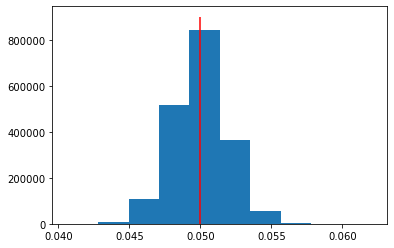

In [29]:
plt.hist(attention_weights)
plt.vlines(x=1/20, ymin=0, ymax=900000, color='red')

In [112]:
for input_dir, dl in tqdm(hek293_dls.items()):
    result_fpath = os.path.join("/data03/christopher/m6anet_new_dataprep_hek293",
                                input_dir, "prod_pooling_attention_pr_auc", "data.result.csv")
    probability_df = pd.read_csv(result_fpath)
    probability_df["read_probability"] = get_read_level_probability(model, dl, device, n_iterations=5)
    probability_df.to_csv(result_fpath, index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [113]:
result_fpath = os.path.join("/data03/christopher/m6anet_new_dataprep_hek293",
                            "GohGIS_Hek293T_directRNA_Rep2", "prod_pooling_attention_pr_auc", "data.result.csv")
probability_df = pd.read_csv(result_fpath)


In [120]:
probability_df

,transcript_id,transcript_position,n_reads,probability_modified,read_probability,genomic_position,kmer,chr,gene_id
0,ENST00000007516,186,172,2.482952e-03,0.783070,23596170,GGACC,chr16,ENSG00000004779
1,ENST00000007516,204,245,5.882570e-01,0.010975,23596152,GGACT,chr16,ENSG00000004779
2,ENST00000007516,307,240,1.960294e-04,0.000794,23587246,GGACC,chr16,ENSG00000004779
3,ENST00000007516,329,233,1.415113e-04,0.006822,23587224,AAACT,chr16,ENSG00000004779
4,ENST00000007516,337,227,1.179422e-11,0.000056,23587216,TGACA,chr16,ENSG00000004779
...,...,...,...,...,...,...,...,...,...
94931,ENST00000641784,3122,58,9.012609e-07,0.031359,97852308,TGACC,chr7,ENSG00000284707
94932,ENST00000641784,3142,62,1.830108e-08,0.010015,97852288,TGACC,chr7,ENSG00000284707
94933,ENST00000641784,3224,63,9.999884e-01,0.179607,97852206,GGACT,chr7,ENSG00000284707
94934,ENST00000641784,3243,62,2.713745e-04,0.007687,97852187,GAACA,chr7,ENSG00000284707


<AxesSubplot:>

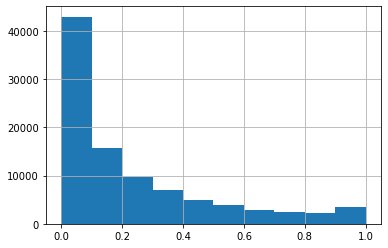

In [116]:
probability_df["read_probability"].hist()

<AxesSubplot:>

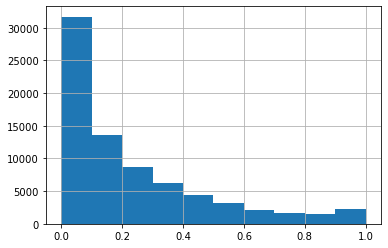

In [121]:
probability_df.groupby(["genomic_position", "gene_id"])["read_probability"].mean().hist()

In [5]:
gt_dir = "/data03/christopher/gt_mapping_final/"
chrsm_annot_dir = "/data03/christopher/annotations/chrsm_annot.txt"
genome = Genome(reference_name='GRCh38',
            annotation_name='my_genome_features',
            gtf_path_or_url='/data03/christopher/annotations/Homo_sapiens.GRCh38.91.chr_patch_hapl_scaff.gtf',
            transcript_fasta_paths_or_urls='/data03/christopher/annotations/Homo_sapiens.GRCh38.cdna.ncrna.fa') 
chr_map = {}
with open(chrsm_annot_dir) as f:
    for line in f:
        ensembl, ucsc = line.strip("\n").split("\t")
        chr_map[ensembl] = ucsc

def add_chromosome_and_gene_info(info_df):
    info_df["chr"] = info_df["transcript_id"].apply(lambda x: chr_map[genome.transcript_by_id(x).contig])
    info_df["gene_id"] = info_df["transcript_id"].apply(lambda x: genome.transcript_by_id(x).gene_id)
    return info_df


def _add_genomic_position(task):
    tx, tx_df = task
    gt_map = pd.read_csv(os.path.join(gt_dir, tx, "gt_mapping.csv.gz")).set_index("tx_pos")
    tx_df["genomic_position"] = gt_map["g_pos"].loc[tx_df["transcript_position"]].values
    tx_df["kmer"] = gt_map["kmer"].loc[tx_df["transcript_position"]].values
    return tx_df


def add_genomic_position(info_df, n_jobs=1):
    with Pool(n_jobs) as p:
        tasks = ((tx, df) for tx, df in info_df.groupby("transcript_id"))
        n_transcripts = len(info_df.transcript_id.unique())
        res_df = [x for x in tqdm(p.imap_unordered(_add_genomic_position, tasks), total=n_transcripts)]
    return pd.concat(res_df).reset_index(drop=True)

In [6]:
for input_dir in tqdm(hek293_dirs):
    result_fpath = os.path.join(input_dir, "prod_pooling_attention_pr_auc", "data.result.csv")
    probability_df = pd.read_csv(result_fpath)
    probability_df = add_genomic_position(probability_df, num_workers)
    probability_df = add_chromosome_and_gene_info(probability_df)
    probability_df.to_csv(result_fpath, index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4662 [00:00<?, ?it/s]

  0%|          | 0/6141 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/4672 [00:00<?, ?it/s]

  0%|          | 0/6423 [00:00<?, ?it/s]

In [122]:
shared_df = None
ko_pcts = ["KO_0", "KO_25", "KO_50", "KO_75", "KO_100"]
features = ["gene_id", "genomic_position", "probability_modified", "read_probability"]
for input_dir, ko_pct in zip(hek293_dirs, ko_pcts):
    result_fpath = os.path.join(input_dir, "prod_pooling_attention_pr_auc", "data.result.csv")
    probability_df = pd.read_csv(result_fpath)[features].groupby(["gene_id", "genomic_position"]).mean().reset_index()
    probability_df = probability_df.rename({'probability_modified': 'probability_modified_{}'.format(ko_pct),
                                            'read_probability': 'read_probability_{}'.format(ko_pct)}, axis=1)
    if shared_df is None:
        shared_df = probability_df
    else:
        shared_df = shared_df.merge(probability_df, on=["gene_id", "genomic_position"])


In [126]:
keys = ["gene_id", "genomic_position"]
proba_cols = ["probability_modified_{}".format(ko_pct) for ko_pct in ko_pcts]
read_proba_cols = ["read_probability_{}".format(ko_pct) for ko_pct in ko_pcts]

/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

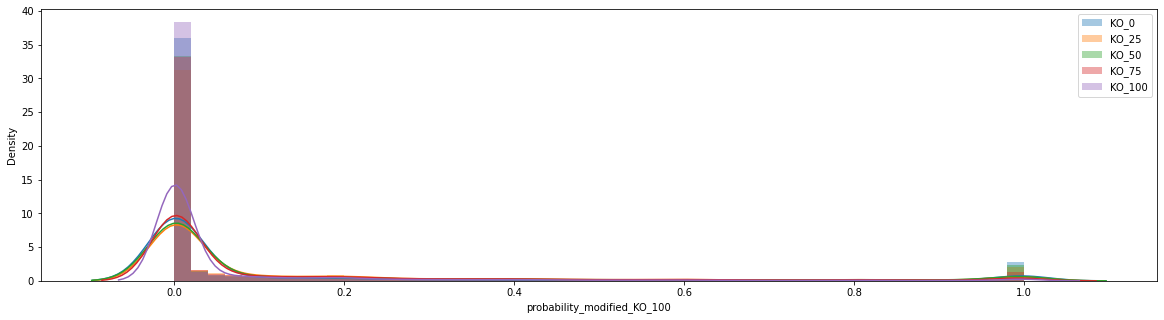

In [127]:
# shared_results_filtered = shared_results_all[~shared_results_all["adj_pval"].isna()]
# shared_results_filtered = shared_results_filtered[shared_results_filtered["adj_pval"] < 0.05]

fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True, sharey=True)
for col, ko_pct in zip(proba_cols, ko_pcts):
    sns.distplot(shared_df[col], ax=ax, label=ko_pct)

plt.legend()

Most sites seems to be not modified. Perhaps we will only see meaningful shifts when we compare those sites that are sensitive to knockouts

In [128]:
shared_df_filtered = shared_df[~shared_df["adj_pvalue"].isna()]
shared_df_filtered = shared_df_filtered[shared_df_filtered["adj_pvalue"] < 0.05]

fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True, sharey=True)
for col, ko_pct in zip(proba_cols, ko_pcts):
    sns.distplot(shared_df_filtered[col], ax=ax, label=ko_pct)

plt.legend()

KeyError: 'adj_pvalue'

<AxesSubplot:xlabel='probability_modified_KO_0', ylabel='read_probability_KO_0'>

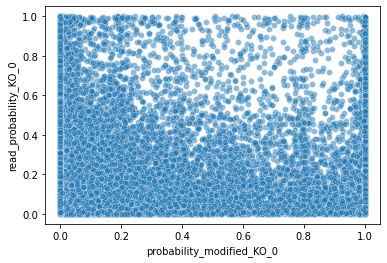

In [129]:
sns.scatterplot(x="probability_modified_KO_0", 
            y="read_probability_KO_0",
            data=shared_df, alpha=0.5)

In [130]:
sort_idx = np.argsort(-shared_df["probability_modified_KO_0"])
adj_pval = shared_df["adj_pvalue"]
plt.hist(adj_pval[sort_idx][:500])

KeyError: 'adj_pvalue'

/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='probability_modified_KO_0', ylabel='Density'>

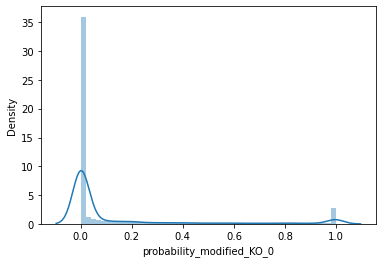

In [131]:
sns.distplot(shared_df["probability_modified_KO_0"], label="site")


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='read_probability_KO_0', ylabel='Density'>

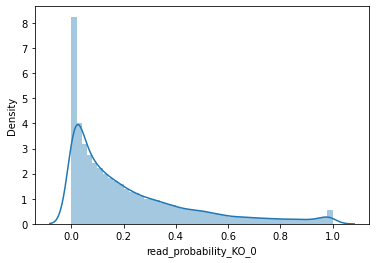

In [132]:
sns.distplot(shared_df["read_probability_KO_0"], label="site")


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


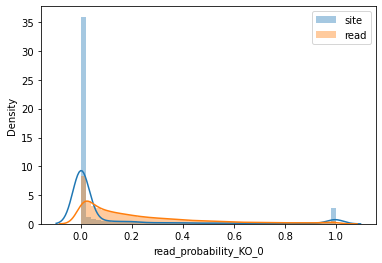

In [133]:
sns.distplot(shared_df["probability_modified_KO_0"], label="site")
sns.distplot(shared_df["read_probability_KO_0"], label="read")
plt.legend()

In [141]:
ko_fpath = "/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz"
ko_table = pd.read_csv(ko_fpath)
ko_table["adj_pvalue"] = multipletests(ko_table["pvalue"], method='fdr_bh')[1]

In [142]:
shared_df = shared_df.merge(ko_table, on=["gene_id", "genomic_position"])

There are 4896 sites in the plot


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'probability_modified_KO_0'),
  Text(1, 0, 'probability_modified_KO_25'),
  Text(2, 0, 'probability_modified_KO_50'),
  Text(3, 0, 'probability_modified_KO_75'),
  Text(4, 0, 'probability_modified_KO_100')])

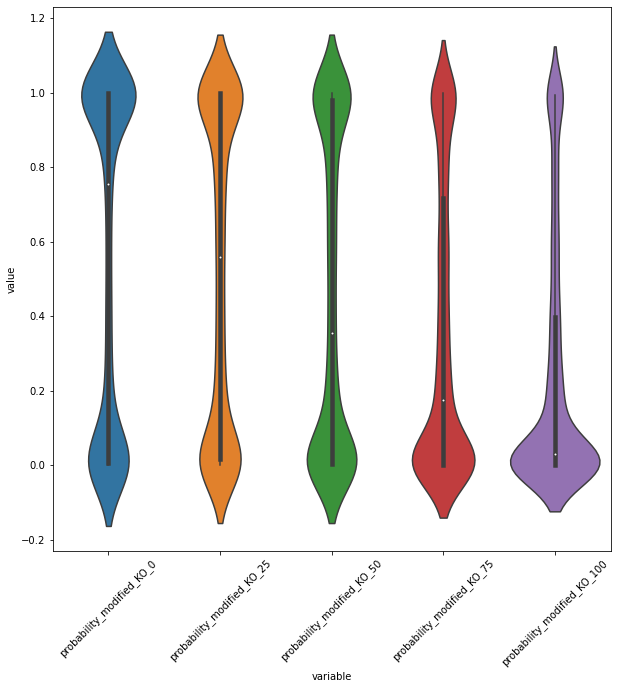

In [143]:
confidence_mask = (shared_df["probability_modified_KO_0"] >= 0) & \
    (shared_df["probability_modified_KO_100"] >=0)
# ko_sensitive_mask = shared_df["adj_pvalue"] < 0.05

shared_df_filtered = shared_df[confidence_mask & ko_sensitive_mask]
print("There are {} sites in the plot".format(len(shared_df_filtered)))

shared_df_filtered_melt = pd.melt(shared_df_filtered, value_vars=proba_cols)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.violinplot(x="variable", y="value", data=shared_df_filtered_melt,
               order=proba_cols,
               ax=ax)
plt.xticks(rotation=45)

There are 845 sites in the plot


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'probability_modified_KO_0'),
  Text(1, 0, 'probability_modified_KO_25'),
  Text(2, 0, 'probability_modified_KO_50'),
  Text(3, 0, 'probability_modified_KO_75'),
  Text(4, 0, 'probability_modified_KO_100')])

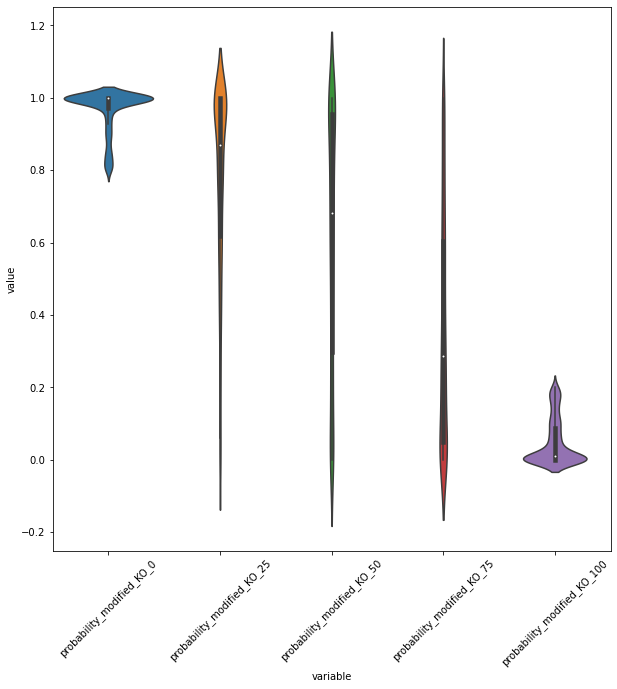

In [144]:
confidence_mask = (shared_df["probability_modified_KO_0"] >= 0.8) & \
    (shared_df["probability_modified_KO_100"] < 0.2)
ko_sensitive_mask = shared_df["adj_pvalue"] < 0.05

shared_df_filtered = shared_df[confidence_mask & ko_sensitive_mask]
print("There are {} sites in the plot".format(len(shared_df_filtered)))

shared_df_filtered_melt = pd.melt(shared_df_filtered, value_vars=proba_cols)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.violinplot(x="variable", y="value", data=shared_df_filtered_melt,
               order=proba_cols,
               ax=ax)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'read_probability_KO_0'),
  Text(1, 0, 'read_probability_KO_25'),
  Text(2, 0, 'read_probability_KO_50'),
  Text(3, 0, 'read_probability_KO_75'),
  Text(4, 0, 'read_probability_KO_100')])

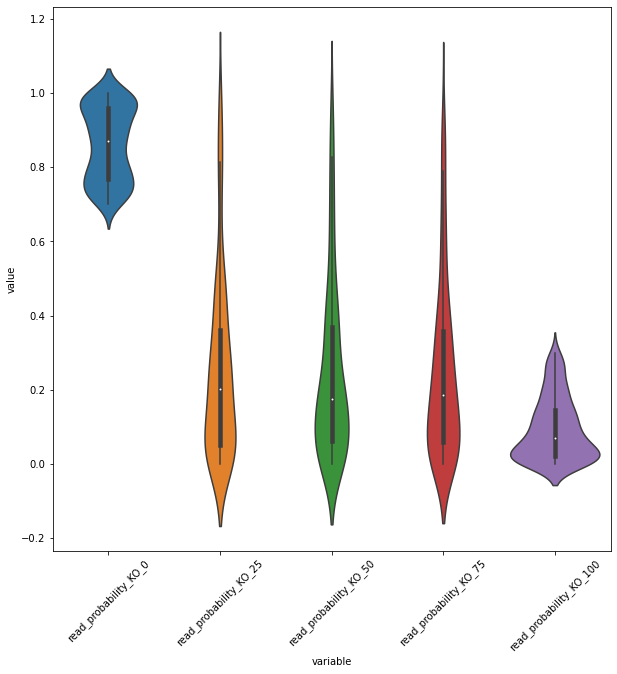

In [147]:
keys = ["gene_id", "genomic_position"]
proba_cols = ["probability_modified_{}".format(ko_pct) for ko_pct in ko_pcts]
read_proba_cols = ["read_probability_{}".format(ko_pct) for ko_pct in ko_pcts]

confidence_mask = (shared_df["read_probability_KO_0"] >= 0.7) & \
    (shared_df["read_probability_KO_100"] < 0.3)
ko_sensitive_mask = shared_df["adj_pvalue"] < 0.05

shared_df_filtered = shared_df[confidence_mask & ko_sensitive_mask]


shared_df_filtered_melt = pd.melt(shared_df_filtered, value_vars=read_proba_cols)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.violinplot(x="variable", y="value", data=shared_df_filtered_melt,
               order=read_proba_cols,
               ax=ax)
plt.xticks(rotation=45)

In [52]:
len(train_results['read_loss'])

710

In [64]:
train_results.keys()

dict_keys(['site_loss', 'read_loss', 'sim_loss', 'compute_time', 'avg_loss', 'accuracy', 'roc_auc', 'pr_auc'])

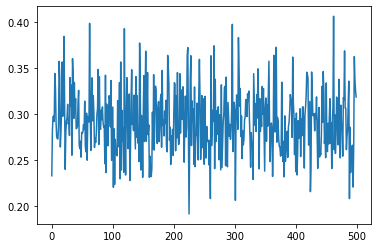

In [93]:
read_loss = []
for x in train_results['read_loss']:
    if isinstance(x, list):
        read_loss = np.append(read_loss, x)
    else:
        try:
            read_loss = np.append(read_loss, [x])
        except Exception:
            print(x)
            raise ValueError()
plt.plot(read_loss[-500:])

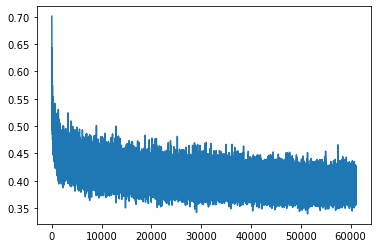

In [78]:
site_loss = []
for x in train_results['site_loss']:
    if isinstance(x, list):
        site_loss = np.append(site_loss, x)
    else:
        try:
            site_loss = np.append(site_loss, [x])
        except Exception:
            print(x)
            raise ValueError()
plt.plot(site_loss)

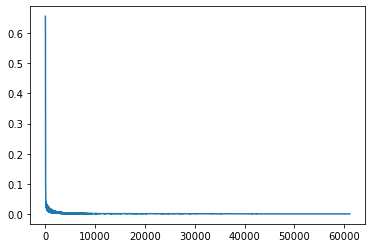

In [79]:
sim_loss = []
for x in train_results['sim_loss']:
    if isinstance(x, list):
        sim_loss = np.append(sim_loss, x)
    else:
        try:
            sim_loss = np.append(sim_loss, [x])
        except Exception:
            print(x)
            raise ValueError()
plt.plot(sim_loss)

In [74]:
site_loss[:5]

array([0.70112813, 0.68923599, 0.67491251, 0.67544842, 0.66587877])

In [75]:
read_loss[:5]

array([6.418015  , 5.87708998, 6.26530552, 5.62429142, 6.55259132])